In [1]:
import boto3
import pandas as pd

s3_bucket = 'jokinatxatfm'
file_key='df_LesionesJugadores.xlsx'

s3 = boto3.client('s3')
s3.download_file(s3_bucket,file_key,file_key)

df_lesiones = pd.read_excel(file_key)

print(df_lesiones)

                            Injury       From         To           Teams  \
0            Lesión de pantorrilla 2015-04-08 2015-05-14  Rayo Vallecano   
1                 Rotura de fibras 2012-01-08 2012-02-05    RCD Espanyol   
2       Rotura del menisco externo 2021-10-30 2021-12-30     Hércules CF   
3               Menisco desgarrado 2021-03-07 2021-08-07     Hércules CF   
4     Rotura del ligamento cruzado 2011-07-17 2012-02-01       Girona FC   
...                            ...        ...        ...             ...   
5678          Problemas musculares 2018-04-02 2018-05-01    RCD Espanyol   
5679  Rotura del ligamento cruzado 2017-03-19 2017-11-09    RCD Espanyol   
5680             Lesión de tobillo 2016-09-26 2016-11-18    RCD Espanyol   
5681               Lesión de muslo 2016-04-18 2016-05-02    RCD Espanyol   
5682           Distensión de muslo 2016-01-11 2016-02-11    RCD Espanyol   

      NumberOfMatches            Player             Izena  \
0                   7  Cri

In [2]:
import pandas as pd

df_lesiones['From'] = pd.to_datetime(df_lesiones['From'])
df_lesiones['To'] = pd.to_datetime(df_lesiones['To'])

# Calcular la diferencia en días
df_lesiones['Recuperacion'] = (df_lesiones['To'] - df_lesiones['From']).dt.days

# Correlaciones

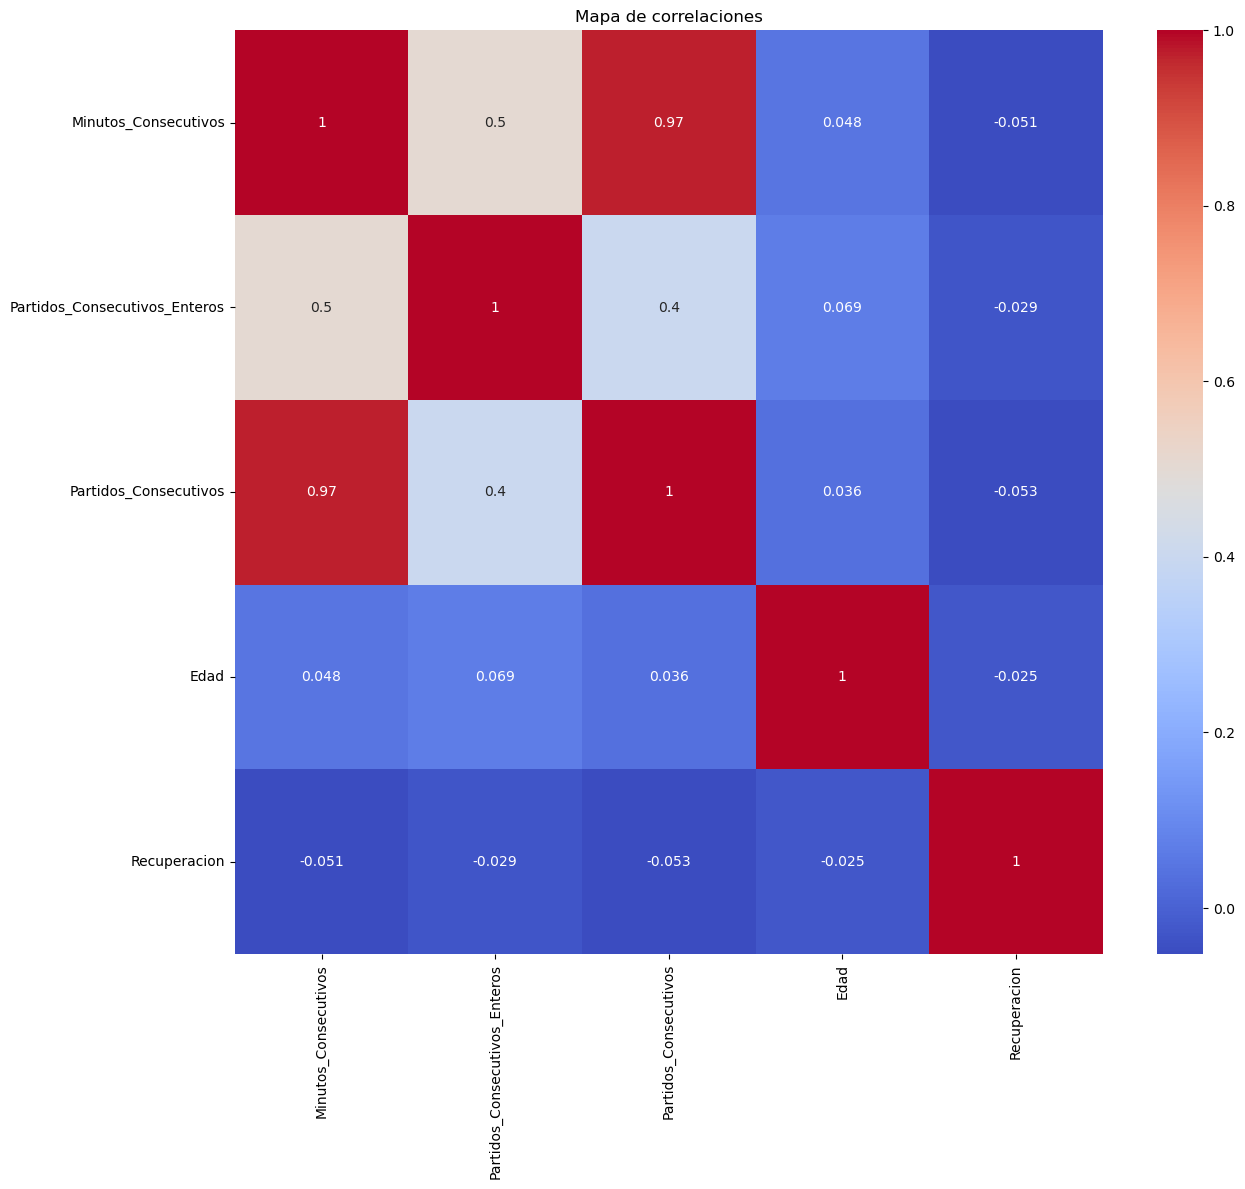

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

#Correlaciones
correlation_matrix = df_lesiones[['Minutos_Consecutivos', 'Partidos_Consecutivos_Enteros','Partidos_Consecutivos','Edad','Recuperacion']].corr()
fig = plt.figure(figsize = (14,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de correlaciones')
plt.show()

# Entrenamiento modelo

In [4]:
df_modelo = df_lesiones[['Recuperacion', 'Partidos_Consecutivos_Enteros',
                         'Partidos_Consecutivos','Edad','Injury','Teams','Posición']]
target = 'Recuperacion'

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_modelo.drop(columns = target),
    df_modelo[target],
    test_size=0.25,
    random_state = 42)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numericos = ['Partidos_Consecutivos_Enteros','Partidos_Consecutivos','Edad']
categoricos = ['Injury','Teams','Posición']

trasnformar_datos = ColumnTransformer(
    transformers=[
        ('normalizar', StandardScaler(), numericos),
        ('categoric', OneHotEncoder(handle_unknown='ignore'), categoricos)])

In [7]:
# Aplica el preprocesamiento a los datos de entrenamiento y prueba
X_train_preprocessed = trasnformar_datos.fit_transform(X_train)
X_test_preprocessed = trasnformar_datos.transform(X_test)

# Regresion lineal

In [8]:
# Ejecución del algoritmo de ML LinearRegression
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train_preprocessed, y_train)

# Predicción sobre el conjunto de test
y_pred_LinearRegression = model.predict(X_test_preprocessed)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred_LinearRegression)
print("Coeficiente de determinación (R2) en el conjunto de validación:", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_LinearRegression)
print("Error cuadrático medio (MSE) en el conjunto de validación:", mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred_LinearRegression)
print("Error absoluto medio (MAE) en el conjunto de validación:", mae)

Coeficiente de determinación (R2) en el conjunto de validación: 0.37919874833286904
Error cuadrático medio (MSE) en el conjunto de validación: 2704.8909172524495
Error absoluto medio (MAE) en el conjunto de validación: 27.00657320035284


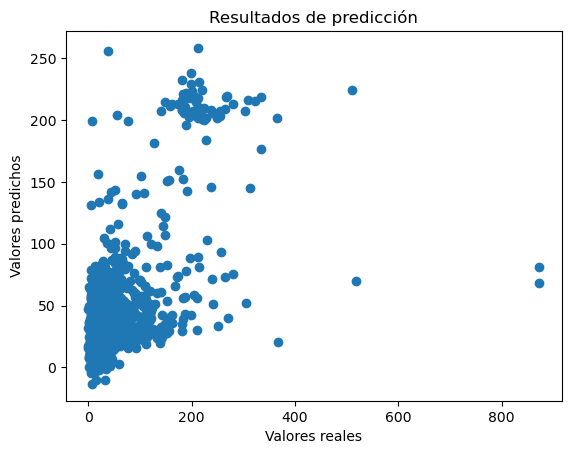

In [10]:
# Graficar los resultados
plt.scatter(y_test, y_pred_LinearRegression)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Resultados de predicción")
plt.show()

# Arbol de decision 1

In [11]:
from sklearn.tree import DecisionTreeRegressor

# Crear y entrenar el modelo de árbol de decisión
modelo = DecisionTreeRegressor()
modelo.fit(X_train_preprocessed, y_train)

# Prediccion
y_pred_DecisionTreeR = modelo.predict(X_test_preprocessed)

In [12]:
# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred_DecisionTreeR)
print("Coeficiente de determinación (R2) en el conjunto de validación:", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_DecisionTreeR)
print("Error cuadrático medio (MSE) en el conjunto de validación:", mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred_DecisionTreeR)
print("Error absoluto medio (MAE) en el conjunto de validación:", mae)

Coeficiente de determinación (R2) en el conjunto de validación: -0.09175820330046092
Error cuadrático medio (MSE) en el conjunto de validación: 4756.895769802174
Error absoluto medio (MAE) en el conjunto de validación: 34.569082805536006


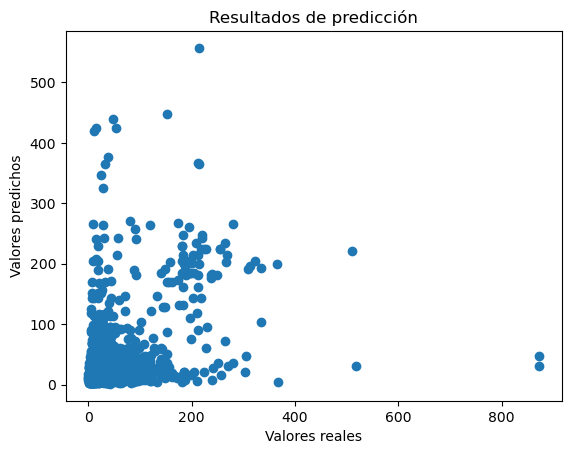

In [13]:
# Graficar los resultados
plt.scatter(y_test, y_pred_DecisionTreeR)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Resultados de predicción")
plt.show()

# Arbol de decision 2 (Hiperparametros) 

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definimos que hiperparametros hay
param_dist = {"max_features": [1.0, 'sqrt'], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [16, 12,8,4, 2,None], # Maximum number of levels in tree
              "min_samples_split": randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": randint(1, 50), # Minimum number of samples required at each leaf node
              "criterion": ["squared_error", "absolute_error"]}

random_search = RandomizedSearchCV(modelo, param_distributions=param_dist, n_iter=20,
                                   cv=5, random_state=42, n_jobs = -1)
random_search.fit(X_train_preprocessed, y_train)

# Los mejores hiperparametros
mejores_hiperparametros = random_search.best_params_
modelo_bueno = random_search.best_estimator_

# Predicciones  conjunto de validacion
y_pred_DecisionTree_B = modelo_bueno.predict(X_test_preprocessed)

In [15]:
# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred_DecisionTree_B)
print("Coeficiente de determinación (R2) en el conjunto de validación:", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_DecisionTree_B)
print("Error cuadrático medio (MSE) en el conjunto de validación:", mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred_DecisionTree_B)
print("Error absoluto medio (MAE) en el conjunto de validación:", mae)

Coeficiente de determinación (R2) en el conjunto de validación: 0.2698487167149821
Error cuadrático medio (MSE) en el conjunto de validación: 3181.3395496129488
Error absoluto medio (MAE) en el conjunto de validación: 26.824771287825474


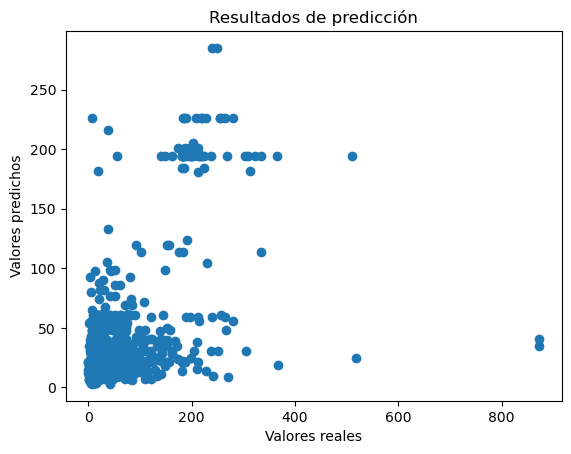

In [16]:
# Graficar los resultados
plt.scatter(y_test, y_pred_DecisionTree_B)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Resultados de predicción")
plt.show()

# Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Definir el modelo RandomForestRegressor
modelo_rf = RandomForestRegressor()

# Definir los hiperparámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['sqrt', 3, 4],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(modelo_rf, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_preprocessed, y_train)

# Obtener el mejor modelo y sus hiperparámetros
mejor_modelo_rf = random_search.best_estimator_
mejores_hiperparametros_rf = random_search.best_params_

# Realizar predicciones en el conjunto de prueba
y_pred_RandomForest = mejor_modelo_rf.predict(X_test_preprocessed)

In [18]:
# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred_RandomForest)
print("Coeficiente de determinación (R2) en el conjunto de validación:", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_RandomForest)
print("Error cuadrático medio (MSE) en el conjunto de validación:", mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred_RandomForest)
print("Error absoluto medio (MAE) en el conjunto de validación:", mae)

Coeficiente de determinación (R2) en el conjunto de validación: 0.3296772960295059
Error cuadrático medio (MSE) en el conjunto de validación: 2920.660660281802
Error absoluto medio (MAE) en el conjunto de validación: 28.969762371514296


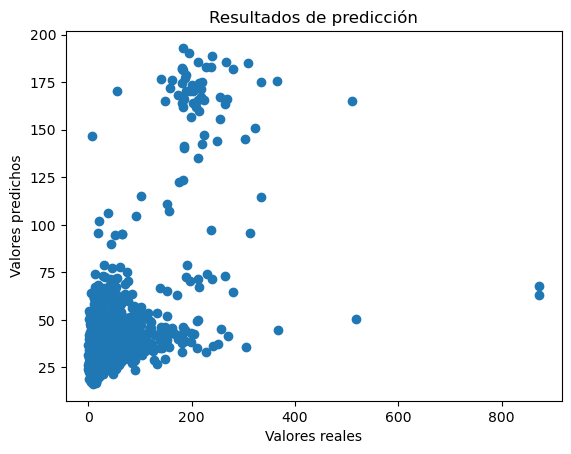

In [19]:
# Graficar los resultados
plt.scatter(y_test, y_pred_RandomForest)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Resultados de predicción")
plt.show()

# KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Crear modelo KNN
modelo = KNeighborsRegressor()

# Definir los hiperparámetros a ajustar
param_dist = {
    "n_neighbors": randint(1, 20),
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(modelo, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_preprocessed, y_train)

# Obtener los mejores hiperparámetros encontrados
mejores_hiperparametros = random_search.best_params_

# Crear un nuevo modelo con los mejores hiperparámetros
modelo_mejor = KNeighborsRegressor(**mejores_hiperparametros)

# Entrenar el modelo con los datos de entrenamiento
modelo_mejor.fit(X_train_preprocessed, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_KNN = modelo_mejor.predict(X_test_preprocessed)

In [21]:
# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred_KNN)
print("Coeficiente de determinación (R2) en el conjunto de validación:", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_KNN)
print("Error cuadrático medio (MSE) en el conjunto de validación:", mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred_KNN)
print("Error absoluto medio (MAE) en el conjunto de validación:", mae)

Coeficiente de determinación (R2) en el conjunto de validación: 0.19649306685508583
Error cuadrático medio (MSE) en el conjunto de validación: 3500.9571897229516
Error absoluto medio (MAE) en el conjunto de validación: 32.32612663875229


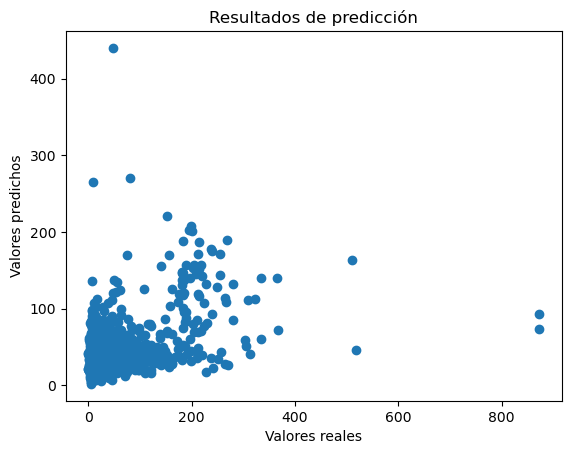

In [22]:
# Graficar los resultados
plt.scatter(y_test, y_pred_KNN)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Resultados de predicción")
plt.show()